In [1]:
import pandas as pd
import numpy as np
import os
import h5py
from copy import deepcopy
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
import seaborn as sns

from utils_plot import *

cm = 1/2.54 
h=5.8*1.1
w=6*1.1

resp_res_path = '/cluster/work/grlab/clinical/hirid2/research/event_based_analysis/resp/'
renal_res_path = '/cluster/work/grlab/clinical/hirid2/research/kdigo_analysis/'
resp_fig_path = '../Figures_Resp'
renal_fig_path = 'paper_figures_renal'

In [3]:
metagroup_mapping = pd.read_csv('/cluster/work/grlab/clinical/Inselspital/DataReleases/01-19-2017/InselSpital/misc_derived/apache_metagroup_name.csv').set_index("meta_group")

In [4]:
# early warning system configuration
renal_ews_configs = dict()
renal_ews_configs.update(pred_win=2880)
renal_ews_configs.update(min_event_gap=0)
renal_ews_configs.update(t_silence=480)
renal_ews_configs.update(t_buffer=0)
renal_ews_configs.update(t_reset=720)

splits = ['temporal_%d'%i for i in np.arange(1,6)]
calibration = False

In [ ]:
curve_ref = {"ref": dict(res_path=os.path.join(renal_res_path, "var28_simple_features_separate_combined_calibrated_lgbm_test_FromZero"),
                         color='C0',
                         linestyle='-',
                         random_classifier=False,
                         splits=splits)}

for k in curve_ref.keys():
    curve_ref[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*2*cm, h*cm))
_, prev_ref = plot_event_based_prc(curve_ref, fixed_rec=1.0)
plt.close()

In [5]:
curves = dict()

for i, apache in enumerate([1,2,3,4,6,7,8,9,11,12,13,14,15,16,17]):
    meta_name = metagroup_mapping.loc[apache,"Name"]
    curves.update({meta_name: dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_apachepatgroup%d_separate_combined_calibrated_lgbm_test_FromZero'%apache),
                                   color='C0',
                                   linestyle='-',
                                   random_classifier=False,
                                   apachegroup=meta_name,
                                   splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*2*cm, h*cm))
_, prev = plot_metric_vs_setting(curves,xlabel="apachegroup",ylabel="precision", fixed_rec=1)
plt.close()

In [7]:
for i, apache in enumerate([1,2,3,4,6,7,8,9,11,12,13,14,15,16,17]):
    prev_adj = prev[i]
    calibrated_s = (1/prev_ref-1) / (1/prev_adj-1)

    meta_name = metagroup_mapping.loc[apache,"Name"]
    curves.update({meta_name: dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_apachepatgroup%d_separate_combined_calibrated_lgbm_test_FromZero'%apache),
                                   color='C0',
                                   linestyle='-',
                                   random_classifier=False,
                                   calibration_scaler=calibrated_s if calibration else 1,
                                   apachegroup=meta_name,
                                   splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
curves_gbdt = deepcopy(curves)

In [8]:
for i, apache in enumerate([1,2,3,4,6,7,8,9,11,12,13,14,15,16,17]):
    prev_adj = prev[i]
    calibrated_s = (1/prev_ref-1) / (1/prev_adj-1)

    meta_name = metagroup_mapping.loc[apache,"Name"]
    curves.update({meta_name: dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_apachepatgroup%d_separate_combined_calibrated_lstm_test_FromZero'%apache),
                                   color='C0',
                                   linestyle='-',
                                   random_classifier=False,
                                   calibration_scaler=calibrated_s if calibration else 1,
                                   apachegroup=meta_name,
                                   splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
curves_lstm = deepcopy(curves)

In [9]:
plt.figure(figsize=(w*2*cm, h*0.5*cm))
metric_gbdt, _ = plot_metric_vs_setting(curves_gbdt,xlabel="apachegroup")
metric_lstm, _ = plot_metric_vs_setting(curves_lstm,xlabel="apachegroup")
plt.close()

In [10]:
all_metric = []
xticks = [curves_gbdt[model]["apachegroup"] for model in curves_gbdt.keys()]
for model, metric in [("Time-stacked GBDT-snapshot", metric_gbdt),
                      ("LSTM", metric_lstm)]:
    metric.loc[:,"Model"] = model    
    all_metric.append(metric)
all_metric = pd.concat(all_metric).reset_index(drop=True)

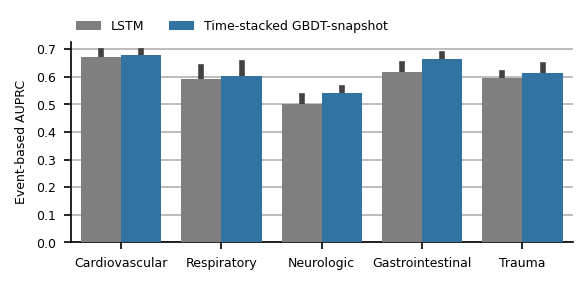

In [11]:
all_metric.loc[:,"surgical"] = all_metric.apachegroup.apply(lambda x: "Non-surgical" if 'surgical' not in x else "Surgical")
all_metric.loc[:,"apachegroup_new"] = all_metric.apachegroup.apply(lambda x: x.replace(" surgical", "").replace("Cardiovascular/vascular","Cardiovascular"))

plt.figure(figsize=(w*1.5*cm, h*0.75*cm))
sns.barplot(all_metric, x="apachegroup_new", y="metric", order=['Cardiovascular', 'Respiratory', 'Neurologic', 'Gastrointestinal', 'Trauma'],
            hue="Model", hue_order=["LSTM", "Time-stacked GBDT-snapshot"], palette=["C7", "C0"],
            zorder=10)
plt.xlabel("")
plt.ylabel("Event-based AUPRC")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncols=2, borderaxespad=0.)
plt.tight_layout()
plt.grid(axis="y")
plt.savefig(os.path.join(renal_fig_path,'apache_fairness_calibrated' if calibration else "apache_fairness_uncalibrated"))
plt.show()  